# A Comparison Between DQN and Actor-Critic in the CartPole Environment

By Giulio Vaccari

Required packages (which can be installed using pip):
*   python=3.7
*   numpy
*   pandas
*   tensorflow
*   matplotlib
*   notebook
*   gym
*   tqdm
*   seaborn


### Project Import

In [ ]:
# Open Gym environment
import gym
# Numerical computation
import numpy as np
# Neural Model Definition
import tensorflow as tf
from tensorflow import keras
# Utility
from collections import deque
from tqdm import tqdm # For the progress bar in the training process
# Visualization
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Constants
IMG_DPI = 200


In [ ]:
# CHECKING TENSORFLOW SUPPORT FOR NVIDIA GPU

print("Checking available GPUs...")
gpu_available = len(tf.config.list_physical_devices('GPU')) > 0
if gpu_available:
    print("GPU available")
else:
    print("GPU not available")

print(tf.config.list_physical_devices('GPU'))

Checking available GPUs...
GPU available
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
# Create gym environment
env = gym.make("CartPole-v1")

print("env.action_space: {}".format(env.action_space))
print("env.observation_space: {}".format(env.observation_space))
print("env.observation_space.shape: {}".format(env.observation_space.shape))
print("env.action_space.n: {}".format(env.action_space.n))

env.action_space: Discrete(2)
env.observation_space: Box(-3.4028234663852886e+38, 3.4028234663852886e+38, (4,), float32)
env.observation_space.shape: (4,)
env.action_space.n: 2


In [ ]:
input_shape = env.observation_space.shape # Shape of a game state / observation
n_actions = env.action_space.n # Number of possible actions available each turn for the agent

### Neural Models Definition

In [ ]:
# DQN Model
dqn_model = keras.Sequential([
    keras.layers.Dense(input_shape=input_shape, units=128, activation="relu"),
    keras.layers.Dense(units=64, activation="relu"),
    keras.layers.Dense(units=n_actions, activation=None),
  ])

dqn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               640       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 130       
Total params: 9,026
Trainable params: 9,026
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# One-step Actor-Critic Model

# Critic
ac_value_network = keras.Sequential([
    keras.layers.Dense(input_shape=input_shape, units=128, activation='relu') ,
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dense(units=1, activation=None)
])
ac_value_network.summary()

# Actor
ac_policy_network = keras.Sequential([
    keras.layers.Dense(input_shape=input_shape, units=128, activation='relu') ,
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dense(units=n_actions, activation='softmax')
])
ac_policy_network.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 128)               640       
_________________________________________________________________
dense_4 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 8,961
Trainable params: 8,961
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 128)               640       
_________________________________________________________________
dense_7 (Dense)              (None, 64)                8256      
______________________________

### Policies Definition

In [ ]:
# DQN Policy
def epsilon_greedy_policy(model, state, n_actions, epsilon=0):
    if np.random.rand() < epsilon:
        # Perform random action
        random_move = np.random.randint(n_actions)
        return random_move
    else:
        # Obtain q-values for each possible action
        q_values = model.predict(state[None])
        # Choose action with maximum value
        return np.argmax(q_values)

In [ ]:
# Actor-Critic Policy
def actor_critic_policy(state, policy_network):
    # Obtain probability distribution over the actions for the specified game state
    p_dist = policy_network.predict(state[None])
    # Sample a random action using that distribution
    action = np.random.choice(n_actions, p=p_dist[0])
    return action

### Experience replay buffers definitions

In [ ]:
dqn_replay_buffer = deque(maxlen=2000)
ac_replay_buffer = deque(maxlen=500)

In [ ]:
def sample_experiences(replay_buffer, batch_size):
    indices = np.random.randint(len(replay_buffer), size=batch_size)
    batch = [replay_buffer[index] for index in indices]
    states, actions, rewards, next_states, dones = [np.array([experience[field_index] for experience in batch]) for field_index in range(5)]
    return states, actions, rewards, next_states, dones

### Training hyperparameters

In [ ]:
# DQN

dqn_batch_size = 32
dqn_discount_factor = 0.95
dqn_optimizer = keras.optimizers.Adam(learning_rate=1e-3)
dqn_loss_fn = keras.losses.mean_squared_error

In [ ]:
# Actor-Critic

ac_batch_size = 32
ac_discount_factor = 0.95

# Loss function used for the critic loss
ac_loss_fn = keras.losses.mean_squared_error

# Regarding the two learning rates, in general it's a good idea to choose a lr for the policy network
# one or two orders of magnitude lower compared to the one of the value network
ac_optimizer_value_network = keras.optimizers.Adam(learning_rate=1e-3)
ac_optimizer_policy_network = keras.optimizers.Adam(learning_rate=1e-5)


### Training methods

In [ ]:
def dqn_training_step(model, loss_fn, replay_buffer, batch_size, optimizer, discount_factor, n_actions):
    # Sample a batch of experiences from the replay buffer
    experiences = sample_experiences(replay_buffer, batch_size)
    # All these are vectors of batch_size length. We will work in a parallel/vector way for each sample in the exp. batch.
    states, actions, rewards, next_states, dones = experiences # S_t, a, R_t+1, S_t+1, done
    # Compute q(S_t+1, a) for each possible action in the next state S_t+1
    next_Q_values = model(next_states)
    # compute max_a q(S_t+1, a, w_t)
    max_next_Q_values = np.max(next_Q_values, axis=1)
    # Compute target q-values
    # R_t+1 + discount_factor * max_a q(S_t+1, a, w_t) if done == 0, else R_t+1
    weighted_max_next_Q_values = (1-dones)*discount_factor*max_next_Q_values
    target_Q_values = (rewards + weighted_max_next_Q_values)
    # mask which represents in a one-hot encoding which actions has been chosen in the state S_t
    mask = tf.one_hot(actions, n_actions)
    with tf.GradientTape() as tape:
        # Compute q values for actions in state S_t
        all_Q_values = model(states) # shape (32, n_actions)
        # set to zero the q-values of the actions different from the one selected in state S_t
        all_Q_values_masked = all_Q_values*mask # shape (32, n_actions)
        # Reduce dimension of the tensor.
        # Now we have a tensor where for each state S_t we have only The q-value of the selected move.
        Q_values = tf.reduce_sum(all_Q_values_masked, axis=1, keepdims=False) # shape (32, 1)
        loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))
    # Compute gradient
    grads = tape.gradient(loss, model.trainable_variables)
    # Apply gradient
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    
    # Save training statistics
    stats = {"loss": loss}
    return stats

In [ ]:
def ac_training_step(policy_network, value_network, loss_fn, replay_buffer, batch_size,
                     optimizer_policy_network, optimizer_value_network, discount_factor, n_actions):
    # Sample a batch of experiences from the replay buffer
    experiences = sample_experiences(replay_buffer, batch_size)
    # All these are vectors of batch_size length. We will work in a parallel/vector way for each sample in the exp. batch.
    states, actions, rewards, next_states, dones = experiences # S_t, a, R_t+1, S_t+1, done
    # Compute V(S_t+1)
    next_state_values = tf.squeeze(value_network(next_states))
    # Compute target state values
    # R_t+1 + discount_factor * V(S_t+1) if done == 0, else R_t+1
    weighted_next_state_values = (1-dones) * discount_factor * next_state_values
    target_state_values = rewards + weighted_next_state_values
    # mask which represents in a one-hot encoding which actions has been chosen in the state S_t
    mask = tf.one_hot(actions, n_actions)
    with tf.GradientTape(persistent=True) as tape:
        # Compute V(S)
        current_state_values = tf.squeeze(value_network(states))
        # Compute the loss of the value network (critic)
        loss_value_network = loss_fn(target_state_values, current_state_values)
        # Compute the probability distribution P(action | S)
        p_dists = policy_network(states)
        # Set to zero the probabilities of the actions different from the one selected in state S_t
        p_dists_masked = p_dists * mask
        # Reduce dimension of the tensor.
        # Now we have a tensor where for each state S_t we have only The probability of the selected move.
        p_selected_actions = tf.reduce_sum(p_dists_masked, axis=1, keepdims=False)
        # Compute the loss of the policy network (actor)
        # -ln(P(action|S)) * ( (R_t+1 + discount_factor * V(S_t+1)) - V(S) )
        p_selected_actions_log = tf.math.log(p_selected_actions)
        loss_policy_network = -p_selected_actions_log * (target_state_values - current_state_values)
        # Reduce the loss computed for each sample in the batch to obtain a single scalar for the full batch.
        loss_value_network_reduced = loss_value_network
        loss_policy_network_reduced = tf.reduce_mean(loss_policy_network)
    
    # Compute gradients
    grad_value_network = tape.gradient(loss_value_network_reduced, value_network.trainable_variables)
    grad_policy_network = tape.gradient(loss_policy_network_reduced, policy_network.trainable_variables)
    # Apply gradients
    optimizer_value_network.apply_gradients(zip(grad_value_network, value_network.trainable_variables))
    optimizer_policy_network.apply_gradients(zip(grad_policy_network, policy_network.trainable_variables))
    del tape
    
    # Save training statistics
    stats = {"loss_value_network": loss_value_network_reduced,
             "loss_policy_network":loss_policy_network_reduced}
    return stats


### Training loop

#### DQN training loop

In [ ]:
# Structures where to store training statistics
total_reward_episode = 0 # Total reward collected in the current episode
dqn_total_rewards_history = [] # History of the total reward collected in each episode
total_setps_num = 0 # Total number of steps executed across all episodes
episode_stats = {"loss":0}
dqn_loss_history = [] # History of the value of the loss function across all episodes

# Training hyperparameters
dqn_number_of_training_episodes = 400
dqn_warm_up_episodes = 50
dqn_max_episode_steps = 1000
dqn_linear_epsilon_scale = 0.6
dqn_min_epsilon = 0.05

# We will use an epsilon that decreases linearly until the dqn_linear_epsilon_ep_scale episode.
# Then the epsilon rate will remain constant at the value of dqn_min_epsilon.
dqn_linear_epsilon_ep_scale = dqn_number_of_training_episodes*dqn_linear_epsilon_scale + dqn_warm_up_episodes
progress_bar = tqdm(range(dqn_number_of_training_episodes + dqn_warm_up_episodes))
for episode in progress_bar:
    state = env.reset()
    for step in range(dqn_max_episode_steps):
        # Update epsilon
        epsilon = max(1 - episode/dqn_linear_epsilon_ep_scale, dqn_min_epsilon)
        # Choose next action and perfrom it in the env
        action = epsilon_greedy_policy(dqn_model, state, n_actions, epsilon)
        next_state, reward, done, info = env.step(action)
        # Store the experience in the replay buffer
        dqn_replay_buffer.append((state, action, reward, next_state, done))
        # Set new state
        state = next_state
        # Update total reward count for current episode
        total_reward_episode = total_reward_episode + reward
        
        if done:
            break
        if episode > dqn_warm_up_episodes:
            # Perform a training step
            stats = dqn_training_step(dqn_model, dqn_loss_fn, dqn_replay_buffer, dqn_batch_size, dqn_optimizer, dqn_discount_factor, n_actions)
            episode_stats["loss"] = episode_stats["loss"] + stats["loss"]
        
        total_setps_num = total_setps_num + 1
    
    if episode > dqn_warm_up_episodes:
        dqn_total_rewards_history.append(total_reward_episode)
        dqn_loss_history.append(episode_stats["loss"]/step)
        
    progress_bar.set_postfix({"Total_steps":total_setps_num,
                              "total_reward_last_episode":total_reward_episode})
    
    episode_stats["loss"] = 0
    total_reward_episode = 0


100%|██████████| 450/450 [46:29<00:00,  6.20s/it, Total_steps=57848, total_reward_last_episode=199]


#### Actor-Critic training loop

In [ ]:
# Structures where to store training statistics
total_reward_episode = 0 # Total reward collected in the current episode
ac_total_rewards_history = [] # History of the total reward collected in each episode
total_setps_num = 0 # Total number of steps executed across all episodes
episode_stats = {"loss_value_network": 0,
                 "loss_policy_network":0}
ac_loss_value_network_history = [] # History of the value of the critic loss across all episodes
ac_loss_policy_network_history = [] # History of the value of the actor loss across all episodes

# Training hyperparameters
ac_number_of_training_episodes = 400
ac_warm_up_episodes = 20
ac_max_episode_steps = 1000

progress_bar = tqdm(range(ac_number_of_training_episodes + ac_warm_up_episodes))
for episode in progress_bar:
    state = env.reset()
    for step in range(ac_max_episode_steps):
        # Choose next action and perfrom it in the env
        action = actor_critic_policy(state, ac_policy_network)
        next_state, reward, done, info = env.step(action)
        # Store the experience in the replay buffer
        ac_replay_buffer.append((state, action, reward, next_state, done))
        # Set new state
        state = next_state
        # Update total reward count for current episode
        total_reward_episode = total_reward_episode + reward
        
        if done:
            break
        if episode > ac_warm_up_episodes:
            # Perform a training step
            stats = ac_training_step(ac_policy_network, ac_value_network, ac_loss_fn, ac_replay_buffer, ac_batch_size,
                                     ac_optimizer_policy_network, ac_optimizer_value_network, ac_discount_factor, n_actions)
            episode_stats["loss_value_network"] = episode_stats["loss_value_network"] + stats["loss_value_network"]
            episode_stats["loss_policy_network"] = episode_stats["loss_policy_network"] + stats["loss_policy_network"]
        
        total_setps_num = total_setps_num + 1
    
    if episode > ac_warm_up_episodes:
        ac_total_rewards_history.append(total_reward_episode)
        ac_loss_value_network_history.append(episode_stats["loss_value_network"]/step)
        ac_loss_policy_network_history.append(episode_stats["loss_policy_network"]/step)
        
    progress_bar.set_postfix({"Total_steps":total_setps_num,
                              "total_reward_last_episode":total_reward_episode})
    
    episode_stats["loss_value_network"] = 0
    episode_stats["loss_policy_network"] = 0
    total_reward_episode = 0

100%|██████████| 420/420 [1:39:22<00:00, 14.20s/it, Total_steps=92658, total_reward_last_episode=500]


### Evaluation

#### DQN

In [ ]:
# Structures where to store training statistics
total_reward_episode = 0 # Total reward collected in the current episode
dqn_total_rewards_history_eval = [] # History of the total reward collected in each episode
total_setps_num = 0 # Total number of steps executed across all episodes

# Training hyperparameters
dqn_number_of_episodes_eval = 20
dqn_max_episode_steps_eval = 1000
dqn_epsilon_eval = 0.05

progress_bar = tqdm(range(dqn_number_of_episodes_eval))
for episode in progress_bar:
    state = env.reset()
    for step in range(dqn_max_episode_steps_eval):
        # Choose next action and perfrom it in the env
        action = epsilon_greedy_policy(dqn_model, state, n_actions, dqn_epsilon_eval)
        next_state, reward, done, info = env.step(action)
        # Set new state
        state = next_state
        # Update total reward count for current episode
        total_reward_episode = total_reward_episode + reward
        
        if done:
            break
        
        total_setps_num = total_setps_num + 1
    
    dqn_total_rewards_history_eval.append(total_reward_episode)
        
    progress_bar.set_postfix({"Total_steps":total_setps_num,
                              "total_reward_last_episode":total_reward_episode})
    total_reward_episode = 0


100%|██████████| 20/20 [02:34<00:00,  7.73s/it, Total_steps=3615, total_reward_last_episode=188]


In [ ]:
dqn_average_reward = sum(dqn_total_rewards_history_eval) / len(dqn_total_rewards_history_eval)
print("Average reward for the DQN agent: {}".format(round(dqn_average_reward,2)))

Average reward for the DQN agent: 181.75


#### Actor-Critic

In [ ]:
# Structures where to store training statistics
total_reward_episode = 0 # Total reward collected in the current episode
ac_total_rewards_history_eval = [] # History of the total reward collected in each episode
total_setps_num = 0 # Total number of steps executed across all episodes

# Training hyperparameters
ac_number_of_episodes_eval = 20
ac_max_episode_steps_eval = 1000

progress_bar = tqdm(range(ac_number_of_episodes_eval))
for episode in progress_bar:
    state = env.reset()
    for step in range(ac_max_episode_steps_eval):
        # Choose next action and perfrom it in the env
        action = actor_critic_policy(state, ac_policy_network)
        next_state, reward, done, info = env.step(action)
        # Set new state
        state = next_state
        # Update total reward count for current episode
        total_reward_episode = total_reward_episode + reward
        
        if done:
            break
        
        total_setps_num = total_setps_num + 1
    
    ac_total_rewards_history_eval.append(total_reward_episode)
        
    progress_bar.set_postfix({"Total_steps":total_setps_num,
                              "total_reward_last_episode":total_reward_episode})
    total_reward_episode = 0


100%|██████████| 20/20 [07:16<00:00, 21.82s/it, Total_steps=9742, total_reward_last_episode=302]


In [ ]:
ac_average_reward = sum(ac_total_rewards_history_eval) / len(ac_total_rewards_history_eval)
print("Average reward for the Actor-Critic agent: {}".format(round(ac_average_reward,2)))

Average reward for the Actor-Critic agent: 488.1


### Training Statistics Visualization

In [ ]:
# Apply a smooting average to smooth the time series.
# The function returns both the smoothed time series and the original one, converted into pandas dataframe objects.
def smooth_time_series(points_list, windows_size=3, remove_start_end_nans=True):
    points_list_pd = pd.DataFrame(points_list)
    smoothed_list_pd = points_list_pd.rolling(windows_size, center=True).mean() # Apply moving average
    if remove_start_end_nans:
        return smoothed_list_pd[int(windows_size/2) : -int(windows_size/2)], points_list_pd[int(windows_size/2) : -int(windows_size/2)]
    else:
        return smoothed_list_pd, points_list_pd

#### DQN Specific

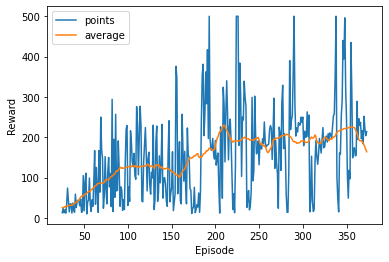

In [ ]:
# Plot total rewards over episodes in training
sl, pl = smooth_time_series(dqn_total_rewards_history, windows_size=50)
plt.plot(pl, label="points")
plt.plot(sl, label="average")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.legend()
plt.savefig("dqn_reward.png", dpi=IMG_DPI)
plt.show()

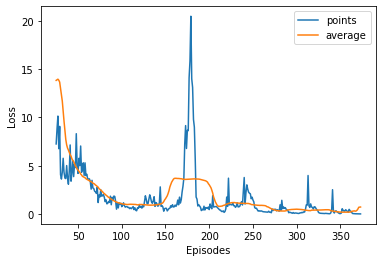

In [ ]:
# Plot the loss of the value network over episodes in training
sl, pl = smooth_time_series(dqn_loss_history, windows_size=50)
plt.plot(pl, label="points")
plt.plot(sl, label="average")
plt.xlabel("Episodes")
plt.ylabel("Loss")
plt.legend()
plt.savefig("dqn_loss.png", dpi=IMG_DPI)
plt.show()

#### Actor-Critic Specific

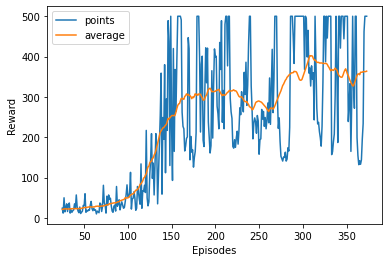

In [ ]:
# Plot total rewards over episodes in training
sl, pl = smooth_time_series(ac_total_rewards_history, windows_size=50)
plt.plot(pl, label="points")
plt.plot(sl, label="average")
plt.xlabel("Episodes")
plt.ylabel("Reward")
plt.legend()
plt.savefig("ac_reward.png", dpi=IMG_DPI)
plt.show()

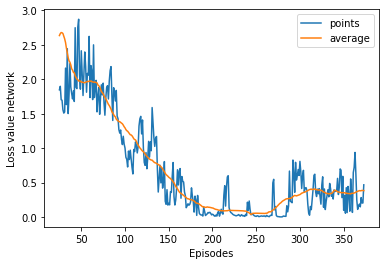

In [ ]:
# Plot the loss of the value network over episodes in training
sl, pl = smooth_time_series(ac_loss_value_network_history, windows_size=50)
plt.plot(pl, label="points")
plt.plot(sl, label="average")
plt.xlabel("Episodes")
plt.ylabel("Loss value network")
plt.legend()
plt.savefig("ac_critic_loss.png", dpi=IMG_DPI)
plt.show()

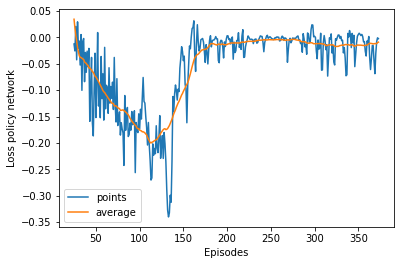

In [ ]:
# Plot the loss of the policy network over episodes in training
sl, pl = smooth_time_series(ac_loss_policy_network_history, windows_size=50)
plt.plot(pl, label="points")
plt.plot(sl, label="average")
plt.xlabel("Episodes")
plt.ylabel("Loss policy network")
plt.legend()
plt.savefig("ac_actor_loss.png", dpi=IMG_DPI)
plt.show()

#### Combined Statistics

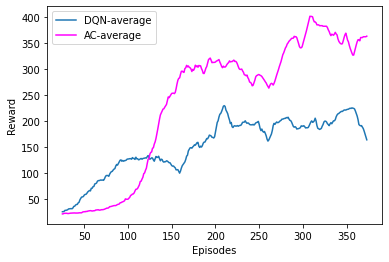

In [ ]:
# Plot total rewards over episodes in training
dqn_sl, qdn_pl = smooth_time_series(dqn_total_rewards_history, windows_size=50)
ac_sl, ac_pl = smooth_time_series(ac_total_rewards_history, windows_size=50)
#plt.plot(qdn_pl, label="DQN")
plt.plot(dqn_sl, label="DQN-average")
#plt.plot(ac_pl, label="AC")
plt.plot(ac_sl, label="AC-average", color="magenta")
plt.xlabel("Episodes")
plt.ylabel("Reward")
plt.legend()
plt.savefig("dqn_ac_comparison.png", dpi=IMG_DPI)
plt.show()

### Policies Visualization

#### DQN Policy Visualization

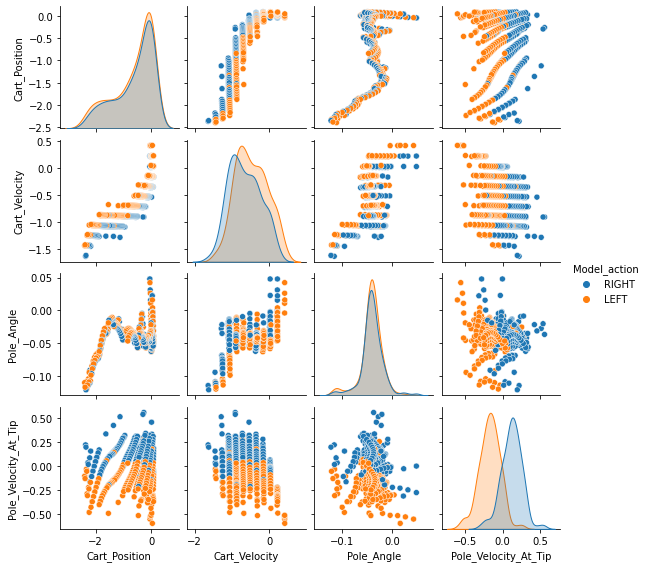

In [ ]:
%matplotlib inline

n_samples_to_collect = 500
df_samples = pd.DataFrame(columns=["Cart_Position", "Cart_Velocity", "Pole_Angle", "Pole_Velocity_At_Tip"])

state = env.reset()
for i in range(n_samples_to_collect):
    action = epsilon_greedy_policy(dqn_model, state, n_actions, dqn_epsilon_eval)
    df_samples = df_samples.append({
        "Cart_Position":state[0],
        "Cart_Velocity":state[1],
        "Pole_Angle":state[2],
        "Pole_Velocity_At_Tip":state[3],
        #"Model_action": action,
        "Model_action": "RIGHT" if action==1 else "LEFT"
    }, ignore_index=True)
    state, reward, done, info = env.step(action)
    if done:
        state = env.reset()
    
sns_dqn_plot = sns.pairplot(df_samples, hue='Model_action', height=2)
sns_dqn_plot.savefig("sns_dqn_plot.png", dpi=IMG_DPI)

#### Actor-Critic Policy Visualization

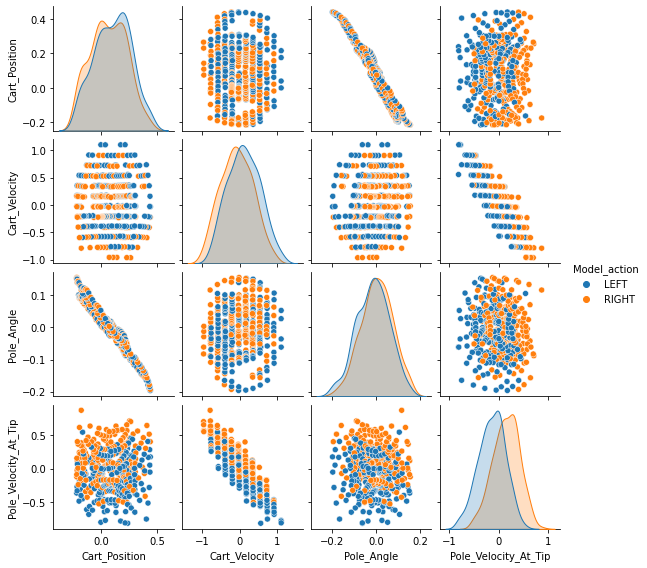

In [ ]:
n_samples_to_collect = 500
df_samples = pd.DataFrame(columns=["Cart_Position", "Cart_Velocity", "Pole_Angle", "Pole_Velocity_At_Tip"])

state = env.reset()
for i in range(n_samples_to_collect):
    action = actor_critic_policy(state, ac_policy_network)
    df_samples = df_samples.append({
        "Cart_Position":state[0],
        "Cart_Velocity":state[1],
        "Pole_Angle":state[2],
        "Pole_Velocity_At_Tip":state[3],
        #"Model_action": action,
        "Model_action": "RIGHT" if action==1 else "LEFT"
    }, ignore_index=True)
    state, reward, done, info = env.step(action)
    if done:
        state = env.reset()
    
sns_ac_plot = sns.pairplot(df_samples, hue='Model_action', height=2)
sns_ac_plot.savefig("sns_ac_plot.png")

### Save models weights

In [ ]:
# DQN
dqn_model.save("dqn_model_nt.h5")

In [ ]:
# Actor-Critic
ac_policy_network.save("ac_policy_nt.h5")
ac_value_network.save("ac_value_nt.h5")